<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (LSTM)

###Load Libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from keras.layers import Dense
from keras.layers import Dropout

###Define Functions to Facilitate Metrics Evaluation

In [73]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [74]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [75]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [76]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

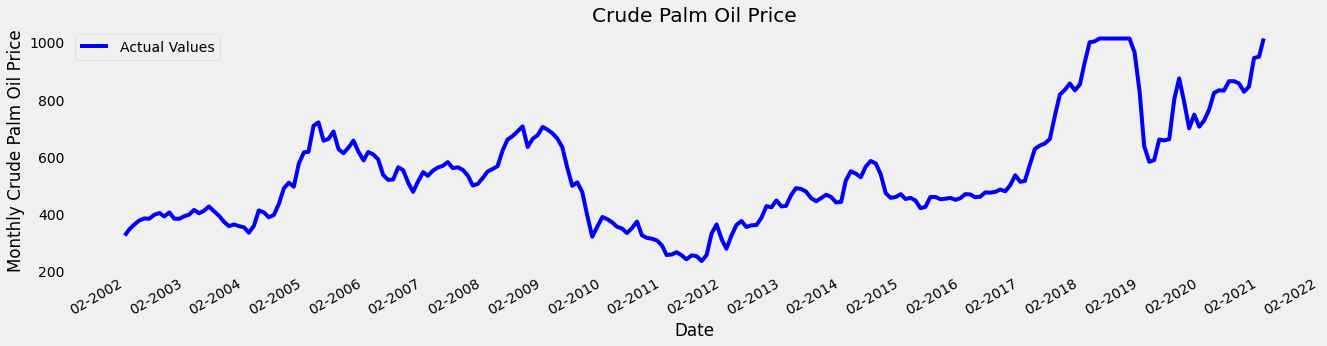

In [77]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [78]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

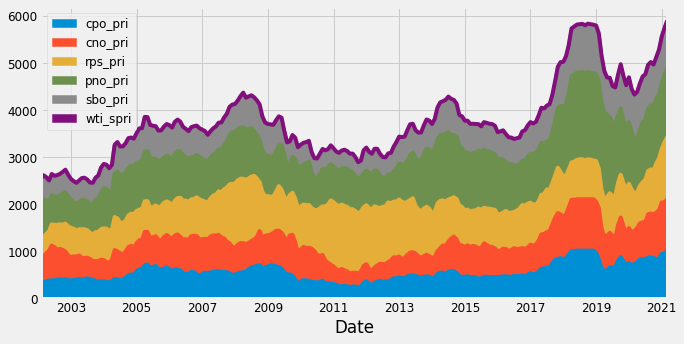

In [79]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**Long Term Short Forecasting Technique**

###**Split Data into Train Test Segments**

In [80]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 184
Test size: 46


In [81]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

184 46


In [82]:
print(train.shape)
train.head()

(184, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [83]:
f_transformer = RobustScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,-0.646119,-1.324544,-0.231262,-0.442244,-0.717978
2002-03-01,345.0,-0.230594,-1.348516,-0.395149,-0.338987,-0.856057
2002-04-01,362.0,-0.006849,-1.364539,-0.690145,-0.454392,-0.936328
2002-05-01,376.0,0.180365,-1.351764,-1.068905,-0.600167,-0.950202
2002-06-01,383.0,0.646119,-1.237519,-1.050696,-0.679128,-0.928400


In [84]:
cpo_pri_transformer = RobustScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01   -0.801187
2002-03-01   -0.670623
2002-04-01   -0.569733
2002-05-01   -0.486647
2002-06-01   -0.445104
Name: cpo_pri, dtype: float64

In [85]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2017-06-01,638.0,0.614155,0.012901,0.597786,0.950695,-0.031877
2017-07-01,645.0,0.760274,0.197485,0.396351,1.058264,-0.007763
2017-08-01,661.0,0.787671,0.100871,0.537949,1.082499,-0.131968
2017-09-01,743.0,1.057078,0.093017,0.621567,1.293083,-0.091007
2017-10-01,816.0,1.358447,0.169917,0.953857,1.505672,-0.215212


In [86]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2017-06-01    1.068249
2017-07-01    1.109792
2017-08-01    1.204748
2017-09-01    1.691395
2017-10-01    2.124629
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [87]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(181, 3, 6) (181,)


###Create Model

####Declare input shape

In [88]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.2))
lstm_model.add(tf.keras.layers.Dense(units=1))
lstm_model.compile(loss='mse', optimizer='adam')

###Train the lstm  model

In [89]:
history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,shuffle=False)

Epoch 1/100
6/6 [==============================] - 2s 107ms/step - loss: 0.4063 - val_loss: 0.0682
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2507 - val_loss: 0.0587
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1766 - val_loss: 0.0510
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1368 - val_loss: 0.0429
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1041 - val_loss: 0.0346
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0910 - val_loss: 0.0275
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0692 - val_loss: 0.0231
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0632 - val_loss: 0.0207
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0594 - val_loss: 0.0191
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0601 - val_loss: 0.0184
Epoch 11/100
6/6 [=

###Model Summary

In [90]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               69120     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


###Predict the Test Data

In [91]:
y_pred = lstm_model.predict(X_test)
y_pred

array([[1.0949316 ],
       [1.2980983 ],
       [1.5582064 ],
       [1.663638  ],
       [1.7636622 ],
       [1.7991542 ],
       [1.8933598 ],
       [1.9492565 ],
       [1.9314111 ],
       [1.8736788 ],
       [1.8540779 ],
       [1.8809618 ],
       [1.8930066 ],
       [1.8752494 ],
       [1.8274121 ],
       [1.8019724 ],
       [1.777587  ],
       [1.6751395 ],
       [1.2938834 ],
       [0.74217004],
       [0.35524258],
       [0.4137516 ],
       [0.9121806 ],
       [1.0635201 ],
       [1.096343  ],
       [1.5907739 ],
       [2.0160623 ],
       [1.9284635 ],
       [1.6028126 ],
       [1.725175  ],
       [1.6345181 ],
       [1.6753582 ],
       [1.8271741 ],
       [1.9557174 ],
       [1.9635495 ],
       [1.9602557 ],
       [2.0515568 ],
       [2.0639575 ],
       [1.9360476 ],
       [1.7989129 ],
       [1.8238857 ],
       [2.0930157 ],
       [2.2035117 ]], dtype=float32)

In [92]:
y_pred.reshape(1,-1)

array([[1.0949316 , 1.2980983 , 1.5582064 , 1.663638  , 1.7636622 ,
        1.7991542 , 1.8933598 , 1.9492565 , 1.9314111 , 1.8736788 ,
        1.8540779 , 1.8809618 , 1.8930066 , 1.8752494 , 1.8274121 ,
        1.8019724 , 1.777587  , 1.6751395 , 1.2938834 , 0.74217004,
        0.35524258, 0.4137516 , 0.9121806 , 1.0635201 , 1.096343  ,
        1.5907739 , 2.0160623 , 1.9284635 , 1.6028126 , 1.725175  ,
        1.6345181 , 1.6753582 , 1.8271741 , 1.9557174 , 1.9635495 ,
        1.9602557 , 2.0515568 , 2.0639575 , 1.9360476 , 1.7989129 ,
        1.8238857 , 2.0930157 , 2.2035117 ]], dtype=float32)

###Inverte Transformed Data

In [93]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370. 354. 348.
  332. 349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254.
  251. 234. 255. 330. 362. 310. 277. 323. 360. 374. 353. 359. 360. 385.
  426. 422. 446. 425. 427. 465. 489. 486. 477. 454. 443. 454. 466. 458.
  439. 441. 515. 548. 540. 527. 564. 584. 575. 537. 471. 455. 458. 468.
  451. 455. 446. 419. 423. 458. 458. 450. 452. 455. 448. 454. 468. 467.
  457. 459. 474. 473. 476. 484. 478. 499. 534. 511. 514. 572. 626.]]
[[ 743.    816.    833.    855.    831.    852.    926.    999.   1

###Plot History, Actual and Predicted Value

In [94]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370., 354., 348., 332.,
       349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.,
       374., 353., 359., 360., 385., 426., 422., 446., 425., 427., 465.,
       489., 486., 477., 454., 443., 454., 466., 458., 439., 441., 515.,
       548., 540., 527., 564., 584., 575., 537., 47

In [95]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 743.  ,  816.  ,  833.  ,  855.  ,  831.  ,  852.  ,  926.  ,
        999.  , 1002.  , 1012.25, 1012.25, 1012.25, 1012.25, 1012.25,
       1012.25, 1012.25,  964.  ,  826.  ,  636.  ,  581.  ,  587.  ,
        659.  ,  656.  ,  660.  ,  800.  ,  873.  ,  789.  ,  698.  ,
        746.  ,  704.  ,  725.  ,  763.  ,  822.  ,  831.  ,  830.  ,
        863.  ,  863.  ,  855.  ,  826.  ,  844.  ,  944.  ,  949.  ,
       1012.25])

In [96]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([642.496  , 676.72955, 720.55774, 738.323  , 755.1771 , 761.1575 ,
       777.0311 , 786.4497 , 783.44275, 773.71484, 770.4121 , 774.942  ,
       776.9716 , 773.9795 , 765.91895, 761.6323 , 757.52344, 740.261  ,
       676.01935, 583.05566, 517.8584 , 527.71716, 611.70245, 637.2031 ,
       642.73376, 726.0454 , 797.7065 , 782.9461 , 728.074  , 748.692  ,
       733.4163 , 740.29785, 765.87885, 787.5384 , 788.8581 , 788.3031 ,
       803.6873 , 805.77686, 784.224  , 761.1168 , 765.3247 , 810.6731 ,
       829.29175], dtype=float32)

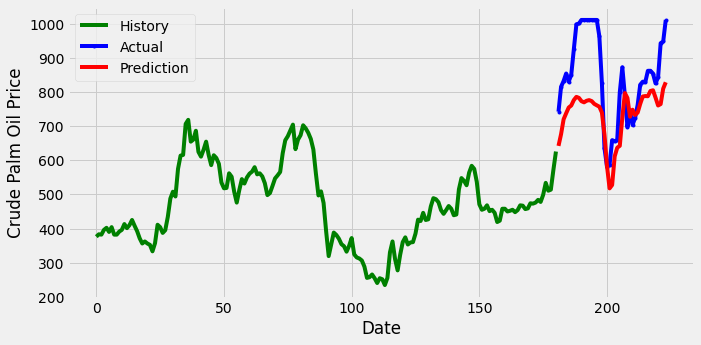

In [97]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Date')
plt.legend()
plt.show();

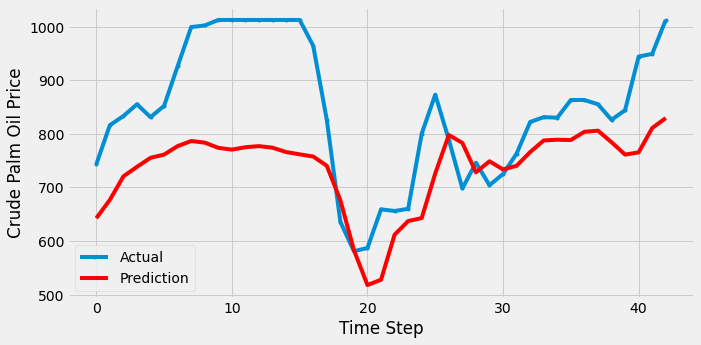

In [98]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Evaluate LSTM Model Accuracy

In [99]:
MAE_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the SVR Model is:', MAE_lstm)

MDA_lstm = mda(y_test_inv, y_pred_inv)
print('MDA value of the SVR Model is:', MDA_lstm)

MAPE_lstm = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the SVR Model is:', MAPE_lstm)

RMSE_lstm = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the SVR Model is:', RMSE_lstm)

MSE_lstm = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the SVR Model is:', MSE_lstm)

EVS_lstm = explained_variance_score(y_test_inv, y_pred_inv)
print('EVS score of the MLP Model is:', EVS_lstm)

MAE value of the SVR Model is: 115.01885134674782
MDA value of the SVR Model is: 0.5238095238095238
MAPE value of the SVR Model is: 12.81945110700098
RMSE value of the SVR Model is: 139.45245316553985
MSE value of the SVR Model is: 19446.986693887084
EVS score of the MLP Model is: 0.4916481410839605


In [ ]:
...updating